In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
# Let's quickly set some options for Pandas
pd.options.display.min_rows = 20

In [3]:
# Link to Data Used = https://github.com/nytimes/covid-19-data

In [4]:
# Let's load in the total US data
total_us_data = pd.read_csv('NYT-US-Data/us-states-2020-04-25.csv')

In [5]:
# Let's narrow it down to the Ohio data
ohio_data = total_us_data[total_us_data.state == 'Ohio']

In [6]:
# Let's give the data a check
ohio_data.tail()

,date,state,fips,cases,deaths
2691,2020-04-20,Ohio,39,12919,509
2746,2020-04-21,Ohio,39,13725,557
2801,2020-04-22,Ohio,39,14117,610
2856,2020-04-23,Ohio,39,14694,656
2911,2020-04-24,Ohio,39,15169,690


In [7]:
# Let's convert the data column to datetime
ohio_data.date = pd.to_datetime(ohio_data.date)

C:\Users\nolan\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [8]:
# And let's make that column the index
ohio_data = ohio_data.set_index('date')

In [9]:
# Looks good
ohio_data.tail()

,state,fips,cases,deaths
date,,,,
2020-04-20,Ohio,39,12919,509
2020-04-21,Ohio,39,13725,557
2020-04-22,Ohio,39,14117,610
2020-04-23,Ohio,39,14694,656
2020-04-24,Ohio,39,15169,690


In [10]:
# Let's check the change in cases
ohio_data.cases.diff().tail()

date
2020-04-20    1317.0
2020-04-21     806.0
2020-04-22     392.0
2020-04-23     577.0
2020-04-24     475.0
Name: cases, dtype: float64

In [11]:
# And let's make that a column
ohio_data['change_in_cases'] = ohio_data.cases.diff()

In [12]:
# And it looks ready for some graphin
ohio_data.tail()

,state,fips,cases,deaths,change_in_cases
date,,,,,
2020-04-20,Ohio,39,12919,509,1317.0
2020-04-21,Ohio,39,13725,557,806.0
2020-04-22,Ohio,39,14117,610,392.0
2020-04-23,Ohio,39,14694,656,577.0
2020-04-24,Ohio,39,15169,690,475.0


## Let's Make a Graph

In [13]:
# I copied the function from my Change in Cases pages and removed a ot of unneeded lines
def daily_change(state, title=None, easter=None):
    plt.figure(figsize=(16, 8))
    
    if title == None:
        plt.title(label=f"{state.state[0]} Currently Has {state.cases[-1]} Cases In Total", size=24)
    else:
        plt.title(title, size=24)
    
    plt.plot(state.change_in_cases)
    
    # This adds Easter's markers, so it will noramally not be used
    if easter != None:
        plt.vlines(x=dt.date(2020, 4, 12), ymin=state.change_in_cases.min(), ymax=state.change_in_cases.max(), linestyles='solid', color='goldenrod', label='Easter Sunday')
        plt.vlines(x=dt.date(2020, 4, 19), ymin=state.change_in_cases.min(), ymax=state.change_in_cases.max(), linestyle='dashdot', color='goldenrod', label='One Week After Easter')
    
    # This will add text at the end of the line indicating the current number of cases
#     plt.text(x=state.index[-2], y=(state.change_in_cases[-1])*0.7, s=f"{state.cases[-1]}\nCases\nTotal", fontsize=16)
    # ^ Marking this out for now because no one line of code looks good for every state ^
    
    # Hopefully the positioning of the 
    plt.legend()

C:\Users\nolan\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


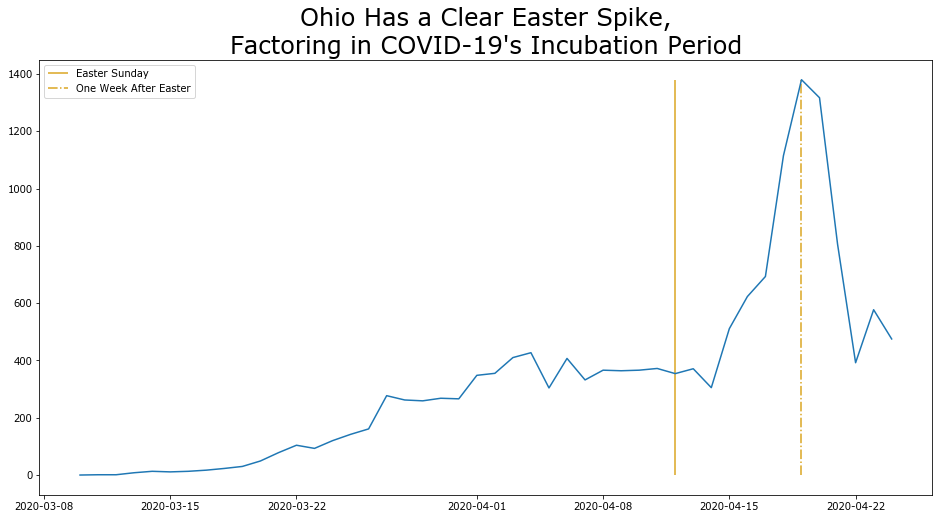

In [14]:
# And let's see how it looks
daily_change(ohio_data, "Ohio Has a Clear Easter Spike,\nFactoring in COVID-19's Incubation Period",easter='On')

## Linear Regression of Total Data

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [16]:
# Let's create our x and y values
X = ohio_data.index
y = ohio_data.change_in_cases

In [17]:
# Not fully sure what this does, but it stops an error when trying to fit X and y
X = np.asanyarray(X).reshape(-1, 1)

In [18]:
# This drops the NaN from the begining and keeps the shapes the same
X = X[1:]
y = y[1:]

In [19]:
# Let's give it train test splitting, with the training data going up to Easter Sunday
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)

In [20]:
# Let's fit the model
lr = LinearRegression().fit(X_train, y_train)

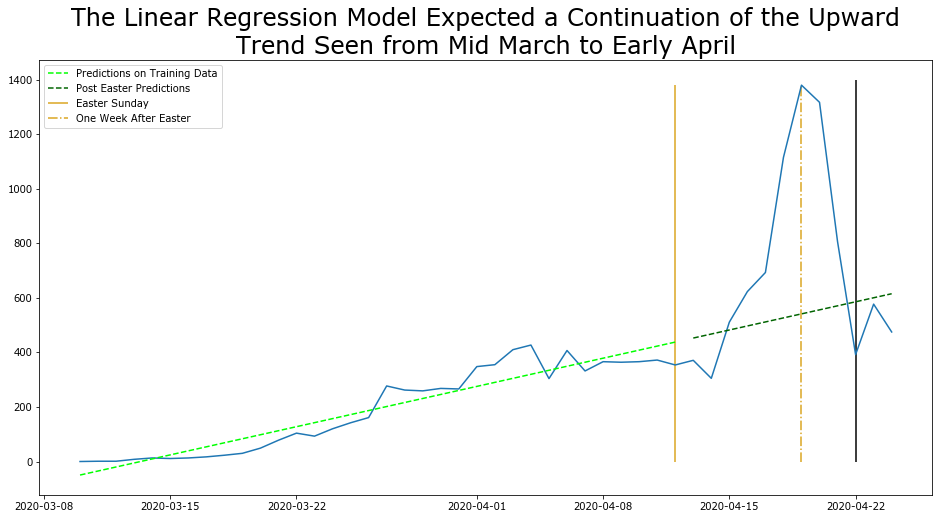

In [22]:
# And let's graph it all out
daily_change(ohio_data, "The Linear Regression Model Expected a Continuation of the Upward\nTrend Seen from Mid March to Early April", easter='On')
plt.plot(X_train, lr.predict(X_train.astype(float)), color='lime', linestyle='dashed', label='Predictions on Training Data')
plt.plot(X_test,  lr.predict(X_test.astype(float)), color='darkgreen', linestyle='dashed', label='Post Easter Predictions')

plt.vlines(x=dt.date(2020, 4, 22), ymin=0, ymax=1400)

plt.legend();

In [30]:
# Let's make a DataFrame to compare 
predictions = pd.DataFrame(data=y_test)
predictions.columns = ['actual']
predictions['predicted'] = lr.predict(X_test.astype(float))
predictions['difference'] = predictions.actual - predictions.predicted
predictions

,actual,predicted,difference
date,,,
2020-04-13,371.0,452.663102,-81.663102
2020-04-14,305.0,467.435447,-162.435447
2020-04-15,511.0,482.207792,28.792208
2020-04-16,623.0,496.980138,126.019862
2020-04-17,693.0,511.752483,181.247517
2020-04-18,1115.0,526.524828,588.475172
2020-04-19,1380.0,541.297173,838.702827
2020-04-20,1317.0,556.069519,760.930481
2020-04-21,806.0,570.841864,235.158136


In [31]:
# And let's see the total difference during the main spike
predictions.difference[dt.date(2020, 4, 15):dt.date(2020, 4, 21)].sum()

2759.3262032083585

In [32]:
# And let's give this a name
cases_caused = int(predictions.difference[dt.date(2020, 4, 15):dt.date(2020, 4, 21)].sum())

In [122]:
# Let's set this value for the graph
preds = pd.DataFrame(lr.predict(X_test.astype(float)))
preds['date'] = pd.date_range(start=dt.date(2020, 4, 13), end=dt.date(2020, 4, 24))
preds.set_index(preds['date'], inplace=True)
preds.drop(columns='date', inplace=True)

In [123]:
preds[0]

date
2020-04-13    452.663102
2020-04-14    467.435447
2020-04-15    482.207792
2020-04-16    496.980138
2020-04-17    511.752483
2020-04-18    526.524828
2020-04-19    541.297173
2020-04-20    556.069519
2020-04-21    570.841864
2020-04-22    585.614209
2020-04-23    600.386555
2020-04-24    615.158900
Name: 0, dtype: float64

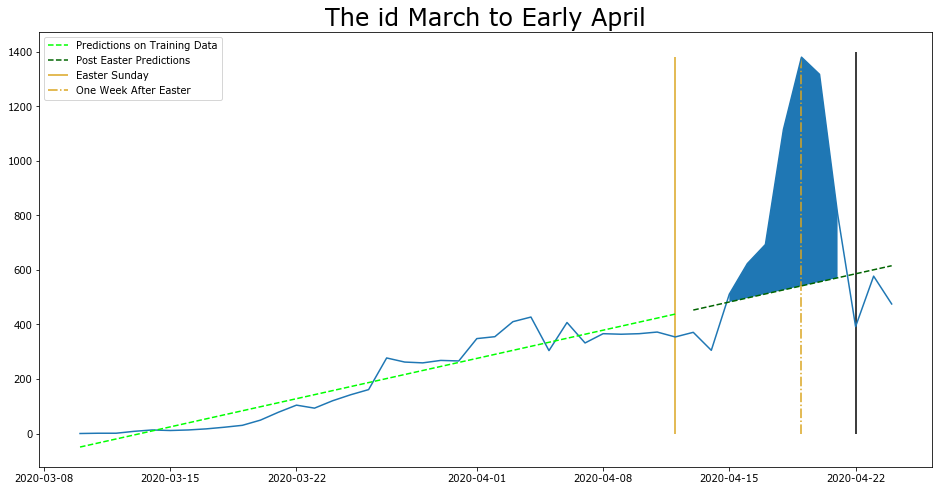

In [124]:
# And let's graph it all out
daily_change(ohio_data, "The id March to Early April", easter='On')
plt.plot(X_train, lr.predict(X_train.astype(float)), color='lime', linestyle='dashed', label='Predictions on Training Data')
plt.plot(X_test, lr.predict(X_test.astype(float)), color='darkgreen', linestyle='dashed', label='Post Easter Predictions')

# This fills in the area of the 2,759 extra cases
plt.fill_between(
    x=np.arange(dt.date(2020, 4, 15), dt.date(2020, 4, 22)), 
    y1=y_test[dt.date(2020, 4, 15):dt.date(2020, 4, 21)], 
    y2=preds[0][dt.date(2020, 4, 15):dt.date(2020, 4, 21)]
)

# This adds the text indicating that ammount
plt.text()

plt.vlines(x=dt.date(2020, 4, 22), ymin=0, ymax=1400)

plt.legend();

## Linear Regression of Recent Data

In [37]:
# This will be about the same as above, but with a slight change to the training data
# Since the large number of low increases in the first few weeks is leading the regressor to predict a constant upward 
# trend that isn't present so much of the month of April, we'll try removing those first few weeks from the training data

In [38]:
# Let's create our x and y values, but only with data starting on April 1st
X_recent = ohio_data.index[18:]
y_recent = ohio_data.change_in_cases[18:]

In [39]:
# Checking that I cut the data properly
y_recent

date
2020-03-27     277.0
2020-03-28     262.0
2020-03-29     259.0
2020-03-30     268.0
2020-03-31     266.0
2020-04-01     348.0
2020-04-02     355.0
2020-04-03     410.0
2020-04-04     427.0
2020-04-05     304.0
2020-04-06     407.0
2020-04-07     332.0
2020-04-08     366.0
2020-04-09     364.0
2020-04-10     366.0
2020-04-11     372.0
2020-04-12     354.0
2020-04-13     371.0
2020-04-14     305.0
2020-04-15     511.0
2020-04-16     623.0
2020-04-17     693.0
2020-04-18    1115.0
2020-04-19    1380.0
2020-04-20    1317.0
2020-04-21     806.0
2020-04-22     392.0
2020-04-23     577.0
2020-04-24     475.0
Name: change_in_cases, dtype: float64

In [40]:
# Still don't fully understand how this helps, but it does
X_recent = np.asanyarray(X_recent).reshape(-1, 1)

In [41]:
# Let's give it train test splitting with the training data being data from the 1st to Easter Sunday
X_train_recent, X_test_recent, y_train_recent, y_test_recent = train_test_split(X_recent, y_recent, test_size=0.4, random_state=42, shuffle=False)

In [42]:
# Let's fit the regressor to the data
lr_recent = LinearRegression().fit(X_train_recent, y_train_recent)

In [43]:
lr_recent.predict(X_test_recent.astype(float))

array([400.51470588, 407.51960784, 414.5245098 , 421.52941176,
       428.53431373, 435.53921569, 442.54411765, 449.54901961,
       456.55392157, 463.55882353, 470.56372549, 477.56862745])

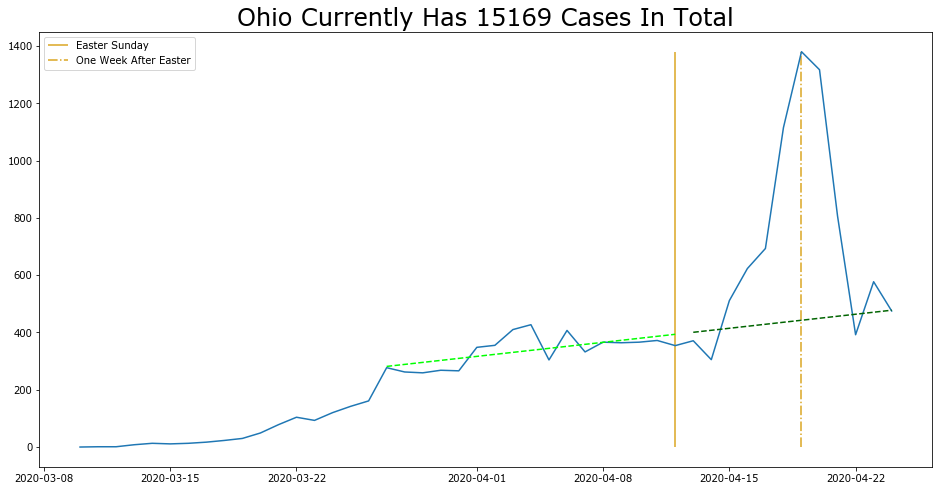

In [44]:
daily_change(ohio_data, easter='On')
plt.plot(X_train_recent, lr_recent.predict(X_train_recent.astype(float)), color='lime', linestyle='dashed', label='Predictions on Training Data')
plt.plot(X_test_recent, lr_recent.predict(X_test_recent.astype(float)), color='darkgreen', linestyle='dashed', label='Post Easter Predictions')

In [45]:
# Let's make a DataFrame to compare 
predictions_recent = pd.DataFrame(data=y_test)
predictions_recent.columns = ['actual']
predictions_recent['predicted'] = lr_recent.predict(X_test_recent.astype(float))
predictions_recent['difference'] = predictions_recent.actual - predictions_recent.predicted
predictions_recent

,actual,predicted,difference
date,,,
2020-04-13,371.0,400.514706,-29.514706
2020-04-14,305.0,407.519608,-102.519608
2020-04-15,511.0,414.524510,96.475490
2020-04-16,623.0,421.529412,201.470588
2020-04-17,693.0,428.534314,264.465686
2020-04-18,1115.0,435.539216,679.460784
2020-04-19,1380.0,442.544118,937.455882
2020-04-20,1317.0,449.549020,867.450980
2020-04-21,806.0,456.553922,349.446078


In [46]:
# And let's see the total difference during the main spike
predictions_recent.difference[dt.date(2020, 4, 15):dt.date(2020, 4, 21)].sum()

3396.2254901960405

In [47]:
# And let's name this
cases_caused_recent = predictions_recent.difference[dt.date(2020, 4, 15):dt.date(2020, 4, 21)].sum()

## Calculating the Percent of the Total

In [ ]:
total_cases_april_24 = ohio_data.cases[-1]
total_cases_april_24

In [ ]:
ohio_data.tail()

## Let's Look at the Counties

In [ ]:
# First we'll read in the county data
county_data = pd.read_csv('NYT-US-Data/us-counties-2020-04-25.csv')

In [ ]:
# Then we narrow it down to Ohio counties
ohio_counties = county_data[county_data.state == 'Ohio']

In [ ]:
# Ohio's got a lot of counties
len(ohio_counties.county.unique())

In [ ]:
ohio_counties.groupby(by='county').max().sort_index(by='cases')